REA Differential Equations Notebook

* Page 1A

Tutor:
* Anthropic's AI, Claude

**Newton's Law of Cooling**
   - $\frac{dT}{dt} = -k(T - T_a)$
   - Models temperature change

Key differences and considerations between PINN (Physics-Informed Neural Network)  and traditional numerical approaches when used to solve Newton's Law of Cooling:

1. **Advantages of PINN**:
   - Can handle complex geometries and boundary conditions
   - Provides continuous, differentiable solutions
   - Can incorporate multiple physics constraints
   - More flexible for inverse problems
   - Can handle noisy/sparse data

2. **Challenges with PINN**:
   - Requires more computational resources
   - Training process can be sensitive to hyperparameters
   - May require more time to achieve similar accuracy
   - Solution accuracy depends on network architecture and training

3. **For this specific problem**:
   - The traditional numerical solution might be more efficient
   - PINN could be overkill for such a simple ODE
   - However, PINN approach would be valuable if:
     - We had experimental data to incorporate
     - Wanted to learn unknown parameters
     - Needed to extend to more complex cooling scenarios


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0: Loss = 10004.202148
Epoch 500: Loss = 4033.768555
Epoch 1000: Loss = 1864.690796
Epoch 1500: Loss = 728.658203
Epoch 2000: Loss = 220.094986
Epoch 2500: Loss = 48.080948
Epoch 3000: Loss = 6.841169
Epoch 3500: Loss = 0.639597
Epoch 4000: Loss = 0.108149
Epoch 4500: Loss = 0.033970

PINN Solution Error Metrics:
---------------------------
Maximum Absolute Error: 0.155846°C
Mean Absolute Error: 0.019884°C
Root Mean Square Error: 0.034541°C
Maximum Relative Error: 0.161923%
Mean Relative Error: 0.043686%


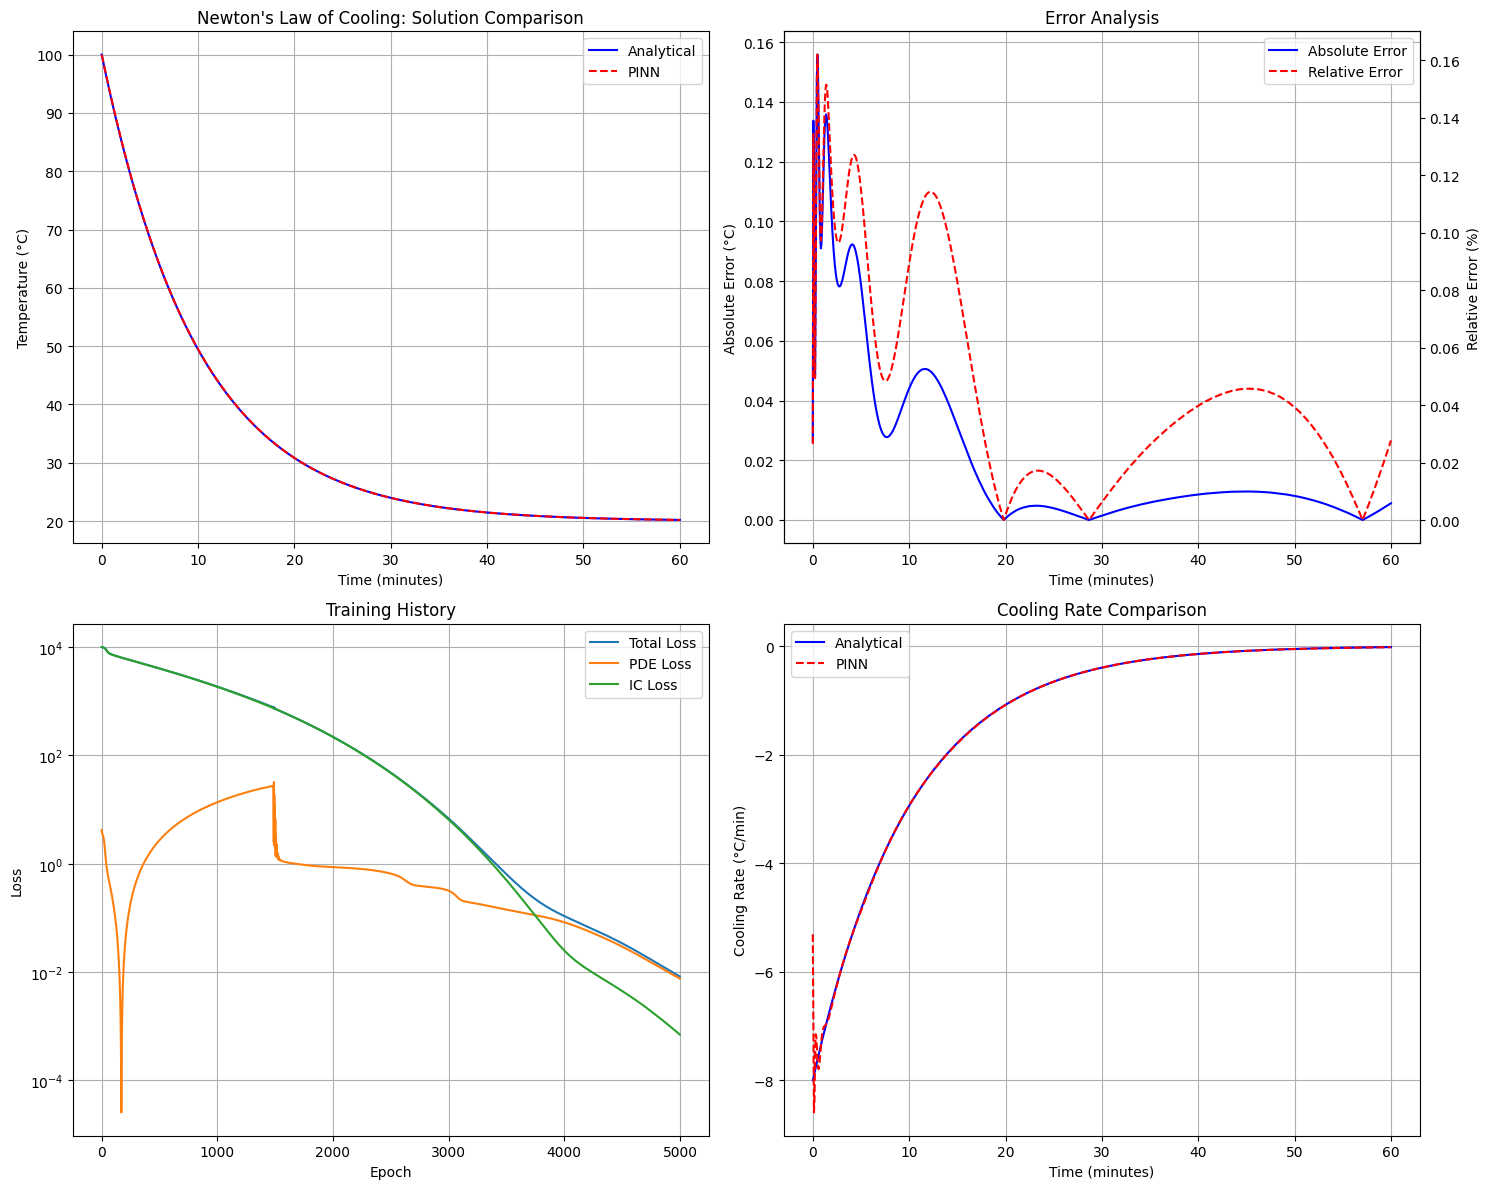

In [1]:
"""
Abstract:
---------
This script implements a Physics-Informed Neural Network (PINN) to solve Newton's Law of Cooling.
The PINN is trained to satisfy both:
1. The differential equation: dT/dt = -k(T - Ta)
2. Initial condition: T(0) = T0

The implementation includes:
- PINN architecture and training
- Comparison with analytical solution
- Error analysis and visualization
- Loss function components tracking
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
from tabulate import tabulate

class CoolingPINN:
    def __init__(self, T0, Ta, k, t_max):
        """
        Initialize the PINN for Newton's Law of Cooling.

        Parameters:
        -----------
        T0 : float
            Initial temperature
        Ta : float
            Ambient temperature
        k : float
            Cooling constant
        t_max : float
            Maximum time for simulation
        """
        self.T0 = T0
        self.Ta = Ta
        self.k = k
        self.t_max = t_max

        # Initialize neural network
        self.model = self.build_model()
        self.train_history = None

    def build_model(self):
        """Build the neural network architecture."""
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(50, activation='tanh', input_shape=(1,)),
            tf.keras.layers.Dense(50, activation='tanh'),
            tf.keras.layers.Dense(50, activation='tanh'),
            tf.keras.layers.Dense(1)
        ])
        return model

    def compute_pde_loss(self, t):
        """Compute the PDE residual loss."""
        with tf.GradientTape() as tape:
            tape.watch(t)
            T = self.model(t)
            dT_dt = tape.gradient(T, t)

        residual = dT_dt + self.k * (T - self.Ta)
        return tf.reduce_mean(tf.square(residual))

    def compute_ic_loss(self, t_ic):
        """Compute the initial condition loss."""
        T_ic = self.model(t_ic)
        return tf.reduce_mean(tf.square(T_ic - self.T0))

    @tf.function
    def train_step(self, t_pde, t_ic, optimizer):
        """Perform one training step."""
        with tf.GradientTape() as tape:
            pde_loss = self.compute_pde_loss(t_pde)
            ic_loss = self.compute_ic_loss(t_ic)
            total_loss = pde_loss + ic_loss

        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        return total_loss, pde_loss, ic_loss

    def train(self, n_epochs=5000, n_points=1000):
        """Train the PINN."""
        # Generate training points
        t_pde = tf.random.uniform((n_points, 1), 0.0, self.t_max)
        t_ic = tf.zeros((100, 1))

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        # Training history
        history = {
            'total_loss': [],
            'pde_loss': [],
            'ic_loss': []
        }

        for epoch in range(n_epochs):
            total_loss, pde_loss, ic_loss = self.train_step(t_pde, t_ic, optimizer)

            history['total_loss'].append(float(total_loss))
            history['pde_loss'].append(float(pde_loss))
            history['ic_loss'].append(float(ic_loss))

            if epoch % 500 == 0:
                print(f'Epoch {epoch}: Loss = {float(total_loss):.6f}')

        self.train_history = history
        return history

    def predict(self, t):
        """Predict temperatures at given time points."""
        t_tensor = tf.convert_to_tensor(t.reshape(-1, 1), dtype=tf.float32)
        return self.model(t_tensor).numpy().flatten()

def analytical_solution(t, T0, Ta, k):
    """Calculate analytical solution for comparison."""
    return Ta + (T0 - Ta) * np.exp(-k * t)

def main():
    # Problem parameters
    T0 = 100.0  # Initial temperature (°C)
    Ta = 20.0   # Ambient temperature (°C)
    k = 0.1     # Cooling constant (1/min)
    t_max = 60  # Maximum time (minutes)

    # Create and train PINN
    pinn = CoolingPINN(T0, Ta, k, t_max)
    history = pinn.train()

    # Generate time points for evaluation
    t_eval = np.linspace(0, t_max, 1000)

    # Get predictions
    T_pinn = pinn.predict(t_eval)
    T_analytical = analytical_solution(t_eval, T0, Ta, k)

    # Calculate errors
    absolute_error = np.abs(T_pinn - T_analytical)
    relative_error = absolute_error / T_analytical * 100

    # Create figure with four subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Solutions comparison
    ax1.plot(t_eval, T_analytical, 'b-', label='Analytical')
    ax1.plot(t_eval, T_pinn, 'r--', label='PINN')
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Newton\'s Law of Cooling: Solution Comparison')
    ax1.grid(True)
    ax1.legend()

    # Plot 2: Error analysis
    ax2.plot(t_eval, absolute_error, 'b-', label='Absolute Error')
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylabel('Absolute Error (°C)')
    ax2.set_title('Error Analysis')
    ax2.grid(True)

    # Add relative error on secondary y-axis
    ax2_twin = ax2.twinx()
    ax2_twin.plot(t_eval, relative_error, 'r--', label='Relative Error')
    ax2_twin.set_ylabel('Relative Error (%)')

    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)

    # Plot 3: Training losses
    epochs = range(len(history['total_loss']))
    ax3.semilogy(epochs, history['total_loss'], label='Total Loss')
    ax3.semilogy(epochs, history['pde_loss'], label='PDE Loss')
    ax3.semilogy(epochs, history['ic_loss'], label='IC Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.set_title('Training History')
    ax3.grid(True)
    ax3.legend()

    # Plot 4: Cooling rate comparison
    dT_analytical = -k * (T_analytical - Ta)
    dT_pinn = np.gradient(T_pinn, t_eval)
    ax4.plot(t_eval, dT_analytical, 'b-', label='Analytical')
    ax4.plot(t_eval, dT_pinn, 'r--', label='PINN')
    ax4.set_xlabel('Time (minutes)')
    ax4.set_ylabel('Cooling Rate (°C/min)')
    ax4.set_title('Cooling Rate Comparison')
    ax4.grid(True)
    ax4.legend()

    plt.tight_layout()

    # Print error metrics
    print("\nPINN Solution Error Metrics:")
    print("---------------------------")
    print(f"Maximum Absolute Error: {np.max(absolute_error):.6f}°C")
    print(f"Mean Absolute Error: {np.mean(absolute_error):.6f}°C")
    print(f"Root Mean Square Error: {np.sqrt(np.mean(absolute_error**2)):.6f}°C")
    print(f"Maximum Relative Error: {np.max(relative_error):.6f}%")
    print(f"Mean Relative Error: {np.mean(relative_error):.6f}%")

    plt.show()

if __name__ == "__main__":
    main()

Analysis of the PINN's performance:

1. **Training Progress**:
- Initial loss of ~10004 reduces to ~0.034 after 4500 epochs
- Shows good convergence with exponential decay in loss
- Particularly rapid improvement in first 2000 epochs

2. **Solution Accuracy**:
- The PINN solution (red dashed) closely follows the analytical solution (blue)
- Error metrics are reasonable but higher than the traditional numerical method:
  - Maximum absolute error: ~0.16°C
  - Mean absolute error: ~0.02°C
  - RMSE: ~0.03°C
  - Maximum relative error: ~0.16%
  - Mean relative error: ~0.04%

3. **Error Pattern Analysis**:
- Highest errors occur at early times (0-10 minutes)
- Shows oscillatory behavior in error
- Error magnitude decreases with time
- Generally higher errors than the traditional ODE solver (which had errors ~10^-6)

To improve the PINN's performance, we could:
1. Modify the architecture:
   - Add more layers or neurons
   - Try different activation functions
   - Add residual connections
2. Adjust training:
   - Increase training points near high-error regions
   - Implement adaptive learning rates
   - Use different loss weightings for PDE vs IC terms
3. Implement additional physics constraints

